<img src=https://www.universidadviu.com/sites/universidadviu.com/themes/custom/universidadviu_com/logo.webp style="height: 100px">
<center style="color:#888">Master en Bigdata y  Data Science<br/>Trabajo Final de Master 2022</center>

## **Identificación de oportunidades de compra en el mercado inmobiliario para alquiler**

**Autor:** Luis Eduardo Rodriguez<br/>
**Módulo:** Modelado/Preparación de datos

### **Descripcion:**

En el siguiente libro se hace analysis de anomalias, dimensionamiento y se preparan los datos para entrenara y probar los modelos


### **Librerias**

In [68]:
#Cargamos librerias con todo lo necesario.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from sklearn.metrics import explained_variance_score

### **Carga de Datos**

Se carga la data colectada con Api idealista

In [69]:
#Lectura CSVs  desde directorio data desde donde esta guardado el libro, todos tiene las mismas columnas
df = pd.DataFrame()
for csv_file in Path('.').glob('data/*.csv'):
    df_aux = pd.read_csv(csv_file, index_col=None, header=0)
    df = df.append(df_aux, ignore_index=True, sort=False)
#df inicial
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9391 entries, 0 to 9390
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              9391 non-null   int64  
 1   propertyCode            9391 non-null   int64  
 2   thumbnail               9328 non-null   object 
 3   externalReference       7401 non-null   object 
 4   numPhotos               9391 non-null   int64  
 5   floor                   8427 non-null   object 
 6   price                   9391 non-null   float64
 7   propertyType            9391 non-null   object 
 8   operation               9391 non-null   object 
 9   size                    9391 non-null   float64
 10  exterior                9391 non-null   bool   
 11  rooms                   9391 non-null   int64  
 12  bathrooms               9391 non-null   int64  
 13  address                 9391 non-null   object 
 14  province                9391 non-null   

### **Limpieza de Datos**

Se aplica todos los cambios  del analisis exploratorio

In [70]:
#Eliminación de features innecesarias
dropcolumns = ['Unnamed: 0', 'thumbnail', 'externalReference', 'numPhotos', 'country',
               'hasVideo', 'newDevelopment','suggestedTexts', 'hasPlan', 'has3DTour',
               'has360', 'hasStaging', 'topNewDevelopment', 'labels', 'newDevelopmentFinished',
              'showAddress', 'priceByArea']
df = df.drop(columns=dropcolumns)

#Eliminación de duplicados
df = df.drop_duplicates(subset="url", keep='first')

#transformación de floors a números enteros y redondeamos a 1 decimal
df['floor'] = df['floor'].replace({'en': 0.5, 'bj': 0, 'ss': -0.5, 'st': -1}).astype(float)
df['floor'] = df['floor'].fillna(df['floor'].mean())
df['floor'] = df['floor'].round(decimals = 1)

#variables campos vacios con false.
df['hasLift'] = df['hasLift'].fillna(False)

#remplazamos Nulos por "{'hasParkingSpace': False, 'isParkingSpaceIncludedInPrice': False}"
df['parkingSpace'] = df['parkingSpace'].fillna("{'hasParkingSpace': False, 'isParkingSpaceIncludedInPrice': False}")

#Convertimos  Parking Space en: hasParkingSpace, isParkingSpaceIncludedInPrice, luego lo removemos
df_aux = df['parkingSpace'].str.split(n=4, expand=True)
df_aux.columns =['h1', 'hasParkingSpace', 'h2', 'isParkingSpaceIncludedInPrice', 'h3']
df_aux['hasParkingSpace'] = df_aux['hasParkingSpace'].replace({'False,': 'False', 'True,': 'True'})
df_aux['isParkingSpaceIncludedInPrice'] = df_aux['isParkingSpaceIncludedInPrice'].replace({'False}': 'False', 'False,': 'False', 'True}': 'True'})
df = pd.concat([df,df_aux[['hasParkingSpace', 'isParkingSpaceIncludedInPrice']]], axis=1).drop(['parkingSpace','isParkingSpaceIncludedInPrice'], axis=1)

# Sustituimos NAN en status por "good"
df['status'] = df['status'].fillna("good")

# Sustituimos NAN en distrito por municipalidades. y en vecindario por distrito
df['district'] = df['district'].fillna(df['municipality'])
df['neighborhood'] = df['neighborhood'].fillna(df['district'])

#Convertimos  detailType en los subgrupos Typology y Subtypology, remplazamos nan  de SubTypology por Typology
df_aux = df['detailedType'].str.split(n=3, expand=True)
df_aux.columns =['h1', 'typology', 'h2', 'subTypology']
df_aux['typology'] = df_aux['typology'].replace({"'chalet',": 'chalet', "'chalet'}": 'chalet',
                                                 "'flat',": 'flat', "'flat'}": 'flat',
                                                 "'countryHouse',": 'countryHouse', "'countryHouse'}": 'countryHouse'})
df_aux['subTypology'] = df_aux['subTypology'].replace({"'casaTerrera'}": 'casaTerrera', "'casale'}": 'casale',
                                                       "'countryHouse'}": 'countryHouse', "'duplex'}": 'duplex',
                                                       "'independantHouse'}": 'independantHouse', "'studio'}": 'studio',
                                                      "'terracedHouse'}": 'terracedHouse', "'penthouse'}": 'penthouse',
                                                      "'semidetachedHouse'}": 'semidetachedHouse'})
df_aux['subTypology'] = df_aux['subTypology'].fillna(df_aux['typology'])

df = pd.concat([df,df_aux[['typology', 'subTypology']]], axis=1).drop(['detailedType','typology'], axis=1)

#Transformamos en variables numéricas  todas  las tipo binario (True or False)
columns = df.loc[: , (df == 'False').any()].columns
for column in columns:
    df[column] = df[column].map({'True': True, 'False': False})
columns = df.select_dtypes('bool').columns
for column in columns:
    df[column] = df[column].astype(float)

#Filtrado de Muestras de barcelona  distance < 5000
df = df[((df['province']=="Barcelona") & (df['distance']<5000)) | (df['province']=="Madrid")]

#Insersion de variable logprice
df['Logprice'] = np.log(df.price.values)

#Quitamos Outlier, para viviendas en venta y alquiler valores obtenidos del analisis exploratorio:
cleaned_df = df[((df['operation']=="rent") & (df['price']<4730)) | (df['operation']=="sale")]
cleaned_df = cleaned_df[((cleaned_df['operation']=="sale") & (cleaned_df['price']<1691000)) | (cleaned_df['operation']=="rent")]

#Quitamos Outlier en el tamaño, en este caso pisos mayores a 296m2
cleaned_df = cleaned_df[cleaned_df['size'] < 296]
#Quitamos Outliers, que vemos que son pisos con más de 9 cuartos
cleaned_df = cleaned_df[cleaned_df['rooms'] <= 9]
#Quitamos Outliers, que vemos que son pisos con más de 5 baños
cleaned_df = cleaned_df[cleaned_df['bathrooms'] <= 5]
#Quitamos Outliers, que vemos que son pisos con más de 13 pisos
cleaned_df = cleaned_df[cleaned_df['floor'] <= 13]

#df  final despues de la limpieza
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7620 entries, 0 to 9389
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   propertyCode     7620 non-null   int64  
 1   floor            7620 non-null   float64
 2   price            7620 non-null   float64
 3   propertyType     7620 non-null   object 
 4   operation        7620 non-null   object 
 5   size             7620 non-null   float64
 6   exterior         7620 non-null   float64
 7   rooms            7620 non-null   int64  
 8   bathrooms        7620 non-null   int64  
 9   address          7620 non-null   object 
 10  province         7620 non-null   object 
 11  municipality     7620 non-null   object 
 12  district         7620 non-null   object 
 13  neighborhood     7620 non-null   object 
 14  latitude         7620 non-null   float64
 15  longitude        7620 non-null   float64
 16  url              7620 non-null   object 
 17  distance      

In [71]:
cleaned_df.columns

Index(['propertyCode', 'floor', 'price', 'propertyType', 'operation', 'size',
       'exterior', 'rooms', 'bathrooms', 'address', 'province', 'municipality',
       'district', 'neighborhood', 'latitude', 'longitude', 'url', 'distance',
       'description', 'status', 'hasLift', 'hasParkingSpace', 'subTypology',
       'Logprice'],
      dtype='object')

### **Separamos Datos de Ventas y Alquiler**

In [72]:
#separamos el dataset por los dos tipos de operación y borramos la etiqueta

df_rent = cleaned_df[cleaned_df['operation']== 'rent']
df_rent = df_rent.drop('operation', axis=1)

df_sale = cleaned_df[cleaned_df['operation']== 'sale']
df_sale = df_sale.drop('operation', axis=1)

## **Revisión de Anomalias**

Seleccionamos las features de interes,  según lo obtenido en el analysis anterior
No se analizaran variables categoricas o de clusterización ya que no se definen como posibles anomalias,  pero si se codificaran durante el entrenamiento.
feature a revisar son:

['floor', 'price', 'size', 'exterior', 'rooms', 'bathrooms', 'distance', 'hasLift', 'hasParkingSpace']

Variables a codificar:
['propertyType', 'province', 'municipality', 'district', 'status']
    

### Seleccionamos fatures

In [73]:
# Seleccionamos features
features=['floor', 'price', 'size', 'exterior', 'rooms', 'bathrooms', 'distance', 'hasLift', 'hasParkingSpace']
df_rent_anomlias = df_rent[features]
df_sale_anomlias = df_sale[features]

In [74]:
df_rent_anomlias.info()
df_sale_anomlias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4236 entries, 0 to 4440
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   floor            4236 non-null   float64
 1   price            4236 non-null   float64
 2   size             4236 non-null   float64
 3   exterior         4236 non-null   float64
 4   rooms            4236 non-null   int64  
 5   bathrooms        4236 non-null   int64  
 6   distance         4236 non-null   int64  
 7   hasLift          4236 non-null   float64
 8   hasParkingSpace  4236 non-null   float64
dtypes: float64(6), int64(3)
memory usage: 330.9 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3384 entries, 4441 to 9389
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   floor            3384 non-null   float64
 1   price            3384 non-null   float64
 2   size             3384 non-null   float

### Escalamos datos (Normalización)

In [75]:
#Usamos RobustScaler para normalizar los datos
from sklearn.preprocessing import RobustScaler
rent_df_anomalias_norm = RobustScaler().fit_transform(df_rent_anomlias)
sale_df_anomalias_norm = RobustScaler().fit_transform(df_sale_anomlias)

### Modelo de deteccción de Anomalias

Usamos la libreria IsolationFores y DBScan para detectar anomalias luego comparamos resultados  

In [76]:

from sklearn.ensemble import IsolationForest

#contaminatio 5% as  it is expected no more than this numbre of outliers based in previous analysis after it was changed to 2%
#iforest = IsolationForest(n_estimators=300, contamination=0.05, random_state=42)
iforest = IsolationForest(n_estimators=300, contamination=0.02, random_state=42)
iforest_sale = iforest.fit(sale_df_anomalias_norm)
iforest_rent = iforest.fit(rent_df_anomalias_norm)

Text(0.5, 1.0, 'rent')

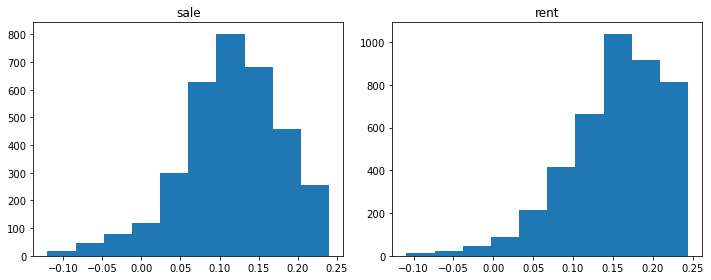

In [77]:
iforest_X_sale = iforest_sale.decision_function(sale_df_anomalias_norm)
iforest_X_rent = iforest_rent.decision_function(rent_df_anomalias_norm)


fig, axs = plt.subplots(1, 2, tight_layout=True,figsize=(10,4))
axs[0].hist(iforest_X_sale)
axs[0].set_title('sale')
axs[1].hist(iforest_X_rent)
axs[1].set_title('rent')

# outliers (samples with decision function < 0) in training

In [78]:
X_outliers_sale = df_sale_anomlias[iforest.predict(sale_df_anomalias_norm) == -1]
X_outliers_rent = df_rent_anomlias[iforest.predict(rent_df_anomalias_norm) == -1]

print('outliers_sale count: ',X_outliers_sale.shape[0])
print('outliers_rent count: ',X_outliers_rent.shape[0])

outliers_sale count:  175
outliers_rent count:  85


In [79]:
X_outliers_sale.head()

,floor,price,size,exterior,rooms,bathrooms,distance,hasLift,hasParkingSpace
4455,4.0,837000.0,209.0,0.0,4,3,7857,1.0,1.0
4457,0.0,415000.0,130.0,1.0,2,3,5223,0.0,1.0
4468,8.0,170000.0,86.0,0.0,2,1,15932,1.0,0.0
4486,0.0,168000.0,66.0,1.0,1,2,16903,0.0,1.0
4488,0.0,725000.0,125.0,1.0,4,3,13196,0.0,1.0


In [80]:
X_outliers_rent.head()

,floor,price,size,exterior,rooms,bathrooms,distance,hasLift,hasParkingSpace
54,4.0,3700.0,280.0,1.0,4,4,2335,1.0,1.0
61,2.7,2500.0,105.0,1.0,0,3,9368,0.0,1.0
62,2.7,2000.0,97.0,1.0,0,3,9667,0.0,1.0
63,2.7,3000.0,132.0,1.0,0,1,9564,0.0,1.0
103,2.0,3200.0,238.0,1.0,5,4,4956,1.0,1.0


#### Outliers con DBSCAN

In [81]:
#Evaluamos el epsilon que mejor se ajusta a los datos de Sales, con distancia minPts= ln(samples) para este grupo seria ln(3384)=8.12
from sklearn.cluster import DBSCAN
minPts=8
for eps in np.arange(0.50, 7, 0.50):
  dbs = DBSCAN(eps, min_samples=minPts).fit(sale_df_anomalias_norm)
  core_samples_mask = np.zeros_like(dbs.labels_, dtype=bool)
  core_samples_mask[dbs.core_sample_indices_] = True
  labels = dbs.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_outliers = list(labels).count(-1)
  print ("%6.2f, %d, %d" % (eps, n_clusters_, n_outliers))

  0.50, 45, 2215
  1.00, 37, 876
  1.50, 2, 114
  2.00, 1, 16
  2.50, 1, 4
  3.00, 1, 0
  3.50, 1, 0
  4.00, 1, 0
  4.50, 1, 0
  5.00, 1, 0
  5.50, 1, 0
  6.00, 1, 0
  6.50, 1, 0


In [82]:
#Evaluamos el epsilon que mejor se ajusta a los datos de rent, con distancia minPts= ln(samples) para este grupo seria ln(4236)=8.35
from sklearn.cluster import DBSCAN
minPts=8
for eps in np.arange(0.50, 7, 0.50):
  dbs = DBSCAN(eps, min_samples=minPts).fit(rent_df_anomalias_norm)
  core_samples_mask = np.zeros_like(dbs.labels_, dtype=bool)
  core_samples_mask[dbs.core_sample_indices_] = True
  labels = dbs.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_outliers = list(labels).count(-1)
  print ("%6.2f, %d, %d" % (eps, n_clusters_, n_outliers))

  0.50, 36, 2030
  1.00, 16, 390
  1.50, 1, 48
  2.00, 1, 5
  2.50, 1, 1
  3.00, 1, 0
  3.50, 1, 0
  4.00, 1, 0
  4.50, 1, 0
  5.00, 1, 0
  5.50, 1, 0
  6.00, 1, 0
  6.50, 1, 0


Nos quedamos con eps=1.5 y min_samples=8 y visualizamso los indices normalizados

Como se puede observar el numero de ouliers es aceptable (< 4% del datatset), **por lo que no vamos a realizar preprocesado durante el modelado.**

A continuación los outliers filtrados para cada dataframe:

In [83]:
from sklearn.cluster import DBSCAN
from collections import Counter

model_dbs_sale = DBSCAN(eps=1.5, min_samples=8).fit(sale_df_anomalias_norm)
model_dbs_rent = DBSCAN(eps=1.5, min_samples=8).fit(rent_df_anomalias_norm)

#outliers_df = pd.DataFrame(z_transform)

print('sale_DBSCAN Labels',Counter(model_dbs_sale.labels_))
print('rent_DBSCAN Labels',Counter(model_dbs_rent.labels_))

#print(outliers_df[model_dbs.labels_==-1])
#z_outlier = df_sale_anomlias
#z_outlier["outliers"]= model_dbs_sale.labels_
#z_outlier[z_outlier["outliers"]==-1].head()

X_outliers_sale = df_sale_anomlias[model_dbs_sale.fit_predict(sale_df_anomalias_norm) == -1]
X_outliers_rent = df_rent_anomlias[model_dbs_rent.fit_predict(rent_df_anomalias_norm) == -1]

print('outliers_sale count: ',X_outliers_sale.shape[0])
print('outliers_rent count: ',X_outliers_rent.shape[0])


sale_DBSCAN Labels Counter({0: 3257, -1: 114, 1: 13})
rent_DBSCAN Labels Counter({0: 4188, -1: 48})
outliers_sale count:  114
outliers_rent count:  48


In [84]:
X_outliers_sale.head()

,floor,price,size,exterior,rooms,bathrooms,distance,hasLift,hasParkingSpace
4488,0.0,725000.0,125.0,1.0,4,3,13196,0.0,1.0
4537,3.0,1680000.0,267.0,1.0,3,4,1409,1.0,1.0
4542,2.7,560000.0,185.0,1.0,2,2,4809,0.0,0.0
4578,2.7,859000.0,230.0,0.0,5,4,8039,0.0,1.0
4584,7.0,495000.0,198.0,1.0,4,3,11640,1.0,0.0


In [85]:
X_outliers_rent.head()

,floor,price,size,exterior,rooms,bathrooms,distance,hasLift,hasParkingSpace
61,2.7,2500.0,105.0,1.0,0,3,9368,0.0,1.0
62,2.7,2000.0,97.0,1.0,0,3,9667,0.0,1.0
63,2.7,3000.0,132.0,1.0,0,1,9564,0.0,1.0
187,2.7,3200.0,200.0,0.0,4,4,13148,0.0,1.0
189,2.7,1300.0,247.0,0.0,3,3,18754,0.0,1.0


## Analisis de dimensionalidad con PCA

Aunque en una primera vista sin codificar las variables categoricas no tenemos muchas features en el dataset, revisamos la explicabilidad del mismo con PCA.

In [88]:
#Cargamos las librerias
from sklearn.decomposition import PCA

#Procesamos datos y generamos un dataFrame para este análisis
sale_df_pca = df_sale_anomlias.drop('price', axis=1)
rent_df_pca = df_rent_anomlias.drop('price', axis=1)

#Usamos RobustScaler
sale_df_pca_normalized = RobustScaler().fit_transform(sale_df_pca)
rent_df_pca_normalized = RobustScaler().fit_transform(rent_df_pca)

### Ejecutamos analisis para 90%

In [92]:
pca_sale=PCA(n_components=0.9).fit(sale_df_pca_normalized)
transform_sale=pca_sale.transform(sale_df_pca_normalized)

pca_rent=PCA(n_components=0.9).fit(rent_df_pca_normalized)
transform_rent=pca_rent.transform(rent_df_pca_normalized)

print("sale components original: ",sale_df_pca_normalized.shape[1])
print("sale components PCA: ",transform_sale.shape[1])

print("rent components original: ",rent_df_pca_normalized.shape[1])
print("rent components PCA: ",transform_rent.shape[1])

sale components original:  8
sale components PCA:  5
rent components original:  8
rent components PCA:  5


### Explicacion de la varianza

In [96]:
var_explicada = pca_sale.explained_variance_ratio_

v_total =0
for v in var_explicada:
    v_total = v_total + v
print('Varianza Sales explicada en %: ',v_total)

var_explicada = pca_rent.explained_variance_ratio_

v_total =0
for v in var_explicada:
    v_total = v_total + v
print('Varianza Rent explicada en %: ',v_total)

Varianza Sales explicada en %:  0.9156749510532305
Varianza Rent explicada en %:  0.9155371592427739


Text(0, 0.5, 'Varianza acumulada')

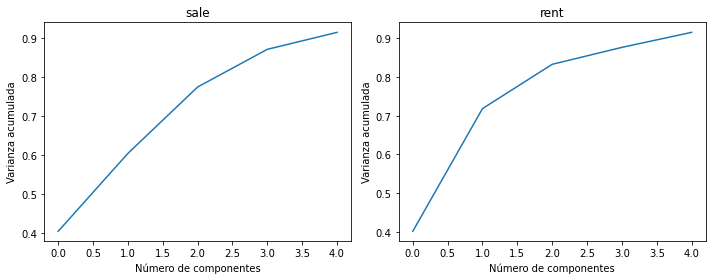

In [104]:
#plt.plot(np.cumsum(pca_sale.explained_variance_ratio_)) 
#plt.xlabel('Número de componentes')
#plt.ylabel('Varianza acumulada')


fig, axs = plt.subplots(1, 2, tight_layout=True,figsize=(10,4))
axs[0].plot(np.cumsum(pca_sale.explained_variance_ratio_))
axs[0].set_title('sale')
axs[0].set_xlabel('Número de componentes')
axs[0].set_ylabel('Varianza acumulada')
axs[1].plot(np.cumsum(pca_rent.explained_variance_ratio_))
axs[1].set_title('rent')
axs[1].set_xlabel('Número de componentes')
axs[1].set_ylabel('Varianza acumulada')
